In [ ]:
# Imports
import cmath
import random
import signal
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from io import StringIO
from matplotlib.patches import Patch
from sympy import *
from tqdm import tqdm

init_printing(use_latex=True)

---
# Problem type 1: Nondimensionalization of a polynomial with random powers (symbolic answer)

For our first type of problem, we choose to do nondimensionalization problems of the format $a_1 x^{n_1} + a_2 x^{n_2} + a_3$ where $n_1 > n_2$


The expected form of the final answer will be $\epsilon y^{n_1} + y^{n_2} + 1$

In [ ]:
# Generates two numbers n1, n2 < max_degree where n1 < n2
def generate_n1n2(max_degree):
    """
    Inputs:
    max_degree (int): Maximum possible degree of polynomial

    Outputs:
    n1 (int): Degree of polynomial
    n2 (int): Second largest power of polynomial
    """
    n2 = random.randint(1, max_degree - 1)
    n1 = random.randint(n2 + 1, max_degree)
    return n1, n2

In [ ]:
# Solves nondimensionalization problem given n1, n2
def nondimensionalize_polynomial1(n1, n2):
    """
    Inputs:
    n1 (int): Degree of polynomial
    n2 (int): Second largest power of polynomial

    Outputs:
    question (string): Latex for problem
    answer (string): Latex for answer
    """
    # Define sympy symbols
    x, y, a1, a2, a3, epsilon = symbols('x y a_1 a_2 a_3 epsilon')

    # Generate sympy polynomial a1*x^n1 + a2*x^n2 + a3
    n1r, n2r = Rational(n1), Rational(n2)
    polynomial_x = a1 * x**n1r + a2 * x**n2r + a3

    # Define x = (a/b)y
    x_sub = ((a3/a2)**Rational(1/n2r)) * y

    # Substitute
    polynomial_y = polynomial_x.subs(x, x_sub).expand()
    # polynomial_y = polynomial_y.subs(x, y).expand()

    # Simplify before dividing by a3
    simplified_polynomial = polynomial_y / a3

    # Further simplify the expression
    final_simplified_polynomial = simplify(simplified_polynomial)

    # Return question and answer
    question = ""
    answer = ""

    question += "Nondimensionalize the polynomial"
    question += "\[" + latex(polynomial_x) + "\]"
    question += f"into one of the form $\epsilon y^{{{n1}}} + y^{{{n2}}} + 1$"

    answer += "Start with the following substitution:"
    answer += "\[" + "x=" + latex(x_sub) + "\]"

    answer += "\nThis gives us the following expression:"
    answer += "\[" + latex(polynomial_y) + "\]"

    answer += "\nDivide by the coefficient remaining in front of the constant, giving us the nondimensionalized polynomial with coefficients in terms of $a_1, a_2, a_3$:"
    answer += "\[ \\boxed{" + latex(final_simplified_polynomial) + "}\]"

    return question, answer

### Sample Usage

In [ ]:
# n1, n2 = generate_n1n2(max_degree=10)
# question, answer = nondimensionalize_polynomial1(n1, n2)

question, answer = nondimensionalize_polynomial1(n1=10, n2=4) # Problem from hw1 to check

print(question)
print(answer)

Nondimensionalize the polynomial\[a_{1} x^{10} + a_{2} x^{4} + a_{3}\]into one of the form $\epsilon y^{10} + y^{4} + 1$
Start with the following substitution:\[x=y \sqrt[4]{\frac{a_{3}}{a_{2}}}\]
This gives us the following expression:\[a_{1} y^{10} \left(\frac{a_{3}}{a_{2}}\right)^{\frac{5}{2}} + a_{3} y^{4} + a_{3}\]
Divide by the coefficient remaining in front of the constant, giving us the nondimensionalized polynomial with coefficients in terms of $a_1, a_2, a_3$:\[ \boxed{\frac{a_{1} y^{10} \left(\frac{a_{3}}{a_{2}}\right)^{\frac{5}{2}}}{a_{3}} + y^{4} + 1}\]


---
# Problem type 2: Nondimensionalization of a polynomial with random powers AND coefficients

The second type of problem is the same as the first, but with a random polynomial (numerical coefficients provided instead of $a_1,~ a_2, a_3$ variables, can also be positive or negative). The goal is then to nondimensionalize it in the same way, and to solve for the value of epsilon.

In [ ]:
# Generates a list of coefficients corresponding to a random polynomial
def generate_polynomial(max_degree, num_terms, coeff_bounds):
    """
    Inputs:
    max_degree (int): The maximum degree of the polynomial.
    num_terms (int)
    coeff_bounds (tuple): (lower bound, upper bound)

    Outputs:
    coefficients (list)
    """
    # Initialize array of coeffs
    coefficients = [0] * (max_degree + 1)
    # Check number of terms
    if num_terms > max_degree + 1:
        raise ValueError("Number of terms cannot be more than the degree of the polynomial + 1")
    # Randomly choose positions for the (#) non-zero coefficients
    non_zero_positions = random.sample(range(max_degree), num_terms - 1)
    # Assign random values within the bounds to the chosen positions
    for pos in non_zero_positions:
        # Loop to make sure it is nonzero bc selecting from [-, +] includes 0
        while coefficients[pos] is None or coefficients[pos] == 0:
          coefficients[pos] = random.randint(coeff_bounds[0], coeff_bounds[1])
    # Ensure the highest degree term is non-zero
    if coefficients[-1] == 0:
        # While loop until it is nonzero
        while coefficients[-1] is None or coefficients[-1] == 0:
          coefficients[-1] = random.randint(coeff_bounds[0], coeff_bounds[1])

    return coefficients

In [ ]:
# Test function
coefficients = generate_polynomial(max_degree=10, num_terms=3, coeff_bounds=[-10,10])
coefficients

In [ ]:
# Helper function to convert list of coefficients into a sympy expression
def sympy_polynomial_from_coefficients(coefficients):
    """
    Inputs:
    coefficients (list): A list of coefficients, where the index represents the power of x.

    Outputs:
    polynomial (sympy expression): The polynomial expression.
    """
    x = symbols('x')
    coefficients_reverse = coefficients
    coefficients_reverse.reverse()
    polynomial = sum(coef * x**i for i, coef in enumerate(coefficients_reverse))
    return polynomial

In [ ]:
# Test helper function
sympy_polynomial_from_coefficients(coefficients)

In [ ]:
# Solves nondimensionalization problem given coefficients
def nondimensionalize_polynomial2(coefficients):
    """
    Inputs:
    coefficients (list): The list of coefficients

    Outputs:
    question (string): Latex for problem
    answer (string): Latex for answer
    """
    question = ""
    answer = ""

    # Find nonzero coefficients & powers in the format [(coefficient, power)]
    nonzero_coeffs = [(coeff, len(coefficients) - idx - 1) for idx, coeff in enumerate(coefficients) if coeff != 0]
    # Find largest, second largest powers
    sorted_coeffs = sorted(nonzero_coeffs, key=lambda x: x[1], reverse=True)
    n1 = sorted_coeffs[0][1]
    n2 = sorted_coeffs[1][1]
    sign1 = np.sign(nonzero_coeffs[0][0])
    sign2 = np.sign(nonzero_coeffs[1][0])
    sign3 = np.sign(nonzero_coeffs[2][0])
    a1_absvalue = abs(nonzero_coeffs[0][0])
    a2_absvalue = abs(nonzero_coeffs[1][0])
    a3_absvalue = abs(nonzero_coeffs[2][0])

    # Define sympy symbols
    x, y, a1, a2, a3, epsilon = symbols('x y a_1 a_2 a_3 epsilon')

    # Generate sympy polynomial a1*x^n1 + a2*x^n2 + a3
    n1r, n2r = Rational(n1), Rational(n2)
    polynomial_x = sign1*a1 * x**n1r + sign2*a2 * x**n2r + sign3*a3 # included signs

    answer += "For now, we ignore the numeric values of the coefficients and instead call them $a_1, a_2, a_3$. Our polynomial is then:"
    answer += "\[" + latex(polynomial_x) + "\]. "

    # Branching for if first coefficient is negative
    if sign1 < 0:
        polynomial_x *= (-1)
        answer += "\nSince the first coefficient is negative, we multiply the entire expression by -1:"
        answer += "\[" + latex(polynomial_x) + "\]"

    # Define x = (a/b)y
    x_sub = ((a3/a2)**Rational(1/n2r)) * y

    # Substitute
    polynomial_y = polynomial_x.subs(x, x_sub).expand()

    # Simplify before dividing by a3
    simplified_polynomial = polynomial_y / a3

    # Further simplify the expression
    final_simplified_polynomial = simplify(simplified_polynomial)

    # Substitute know values for a1, a2, a3
    final_simplified_polynomial_subs = final_simplified_polynomial.subs([(a1, a1_absvalue), (a2, a2_absvalue), (a3, a3_absvalue)]).simplify()

    # Find value of epsilon
    epsilon_value = list(final_simplified_polynomial_subs.expand().args)[::-1][0] / (y**n1)

    # Return question and answer
    question += "Nondimensionalize the polynomial \[P(x) = "
    question += latex(sympy_polynomial_from_coefficients(coefficients)) + "\] "
    question += f"into a polynomial of the form $\epsilon y^{{{n1}}} \pm y^{{{n2}}} \pm 1$. Solve for $\epsilon$."

    answer += "Use the following substitution:"
    answer += "\[" + "x=" + latex(x_sub) + "\]"

    answer += "\nThis gives us the following expression: "
    answer += "\[" + latex(polynomial_y) + "\]."

    answer += "\nDivide all terms by the coefficient remaining in front of the constant term, giving us the nondimensionalized polynomial with coefficients in terms of $a_1, a_2, a_3$: "
    answer += "\[" + latex(final_simplified_polynomial) + "\]"

    answer += "\nSubstituting in the known numeric values for $a_1, a_2, a_3$ (using their absolute values as we have already accounted for sign), we get: "
    answer += "\[" + latex(final_simplified_polynomial_subs) + "\]"

    answer += "\nFrom inspection of this nondimensionalized equation, we can now identify $\epsilon$: "
    answer += "\[ \\boxed{\epsilon=" + latex(epsilon_value) + "}" + f"\\approx{float(epsilon_value.evalf()):.2f} \]"

    return question, answer

In [ ]:
print(coefficients)
question, answer = nondimensionalize_polynomial2(coefficients)

print(question)
print(answer)

[-3, 0, 0, 0, 9, 0, 0, -4, 0, 0, 0]
Nondimensionalize the polynomial \[P(x) = - 3 x^{10} + 9 x^{6} - 4 x^{3}\] into a polynomial of the form $\epsilon y^{10} \pm y^{6} \pm 1$. Solve for $\epsilon$.
For now, we ignore the numeric values of the coefficients and instead call them $a_1, a_2, a_3$. Our polynomial is then:\[- a_{1} x^{10} + a_{2} x^{6} - a_{3}\]. 
Since the first coefficient is negative, we multiply the entire expression by -1:\[a_{1} x^{10} - a_{2} x^{6} + a_{3}\]Use the following substitution:\[x=y \sqrt[6]{\frac{a_{3}}{a_{2}}}\]
This gives us the following expression: \[a_{1} y^{10} \left(\frac{a_{3}}{a_{2}}\right)^{\frac{5}{3}} - a_{3} y^{6} + a_{3}\].
Divide all terms by the coefficient remaining in front of the constant term, giving us the nondimensionalized polynomial with coefficients in terms of $a_1, a_2, a_3$: \[\frac{a_{1} y^{10} \left(\frac{a_{3}}{a_{2}}\right)^{\frac{5}{3}}}{a_{3}} - y^{6} + 1\]
Substituting in the known numeric values for $a_1, a_2, a_3$ (usin

---
# Problem type 3: Solving for roots

Given a nondimensionalized problem of form
$\epsilon x^{n_1} \pm x^{n_2} \pm 1$ where $n_1 > n_2$, find the roots in terms of epsilon (using dominant balances) for both large and small $\epsilon$. This is most similar to the problems we did in class.

In [ ]:
# Generates nondimensionalized polynomial of the form described above
def generate_nondimensionalized(max_n1):
    """
    Inputs:
    max_n1 (int): Maximum power in polynomial

    Outputs:
    polynomial (sympy expression): Nondimensionalized random polynomial of the given format
    """
    # Ensure max_n1 is at least 2
    if max_n1 < 2:
        raise ValueError("max_n1 must be at least 2")

    # Randomly choose n1 and n2
    n1 = random.randint(2, max_n1)
    n2 = random.randint(1, n1 - 1)
    # Randomly choose signs
    signs = random.choices([-1, 1], k=2)

    # Construct polynomial, let first term always be + since same as negating if negative
    x = symbols('x')
    epsilon = symbols('epsilon')
    polynomial = epsilon * x**n1 + signs[0] * x**n2 + signs[1]

    # Return
    return polynomial

In [ ]:
# Example usage of random polynomial generator
polynomial = generate_nondimensionalized(10)
display(polynomial)

In [ ]:
# Function to solve for roots of nondimensionalized polynomial
def solve_roots(polynomial):
    """
    Inputs:
    polynomial (sympy expression): The nondimensionalized polynomial

    Outputs:
    question (string): Latex for problem
    answer (string): Latex for answer
    """
    # Extract terms and solve
    x, epsilon = symbols('x epsilon')
    terms = list(polynomial.expand().args)[::-1]
    A, B, C = terms[0], terms[1], terms[2]
    sol_ab = [simplify(sol) for sol in solve(A + B, x)]
    sol_bc = [simplify(sol) for sol in solve(B + C, x)]
    sol_ac = [simplify(sol) for sol in solve(A + C, x)]

    # Remove extraneous root 0 that shows up - bc it never occurs in this problem formulation
    def remove_zeros(sol_list):
        # Helper function to remove zeros
        while 0 in sol_list:
            sol_list.remove(0)
    remove_zeros(sol_ab)
    remove_zeros(sol_bc)
    remove_zeros(sol_ac)

    # Check dominant balances to see if roots belong to small or large epsilon regimes
    AB_valid_small_eps = (abs(A.subs(x, sol_ab[0]).subs(epsilon, 0.0001)) > abs(C.subs(x, sol_ab[0]).subs(epsilon, 0.001))) # A,B >> C small eps
    AB_valid_large_eps = (abs(A.subs(x, sol_ab[0]).subs(epsilon, 10000)) > abs(C.subs(x, sol_ab[0]).subs(epsilon, 1000))) # A,B >> C large eps
    AB_validity = "small" if AB_valid_small_eps else "large"

    BC_valid_small_eps = (abs(B.subs(x, sol_bc[0]).subs(epsilon, 0.0001)) > abs(A.subs(x, sol_bc[0]).subs(epsilon, 0.001))) # B,C >> A small eps
    BC_valid_large_eps = (abs(B.subs(x, sol_bc[0]).subs(epsilon, 10000)) > abs(A.subs(x, sol_bc[0]).subs(epsilon, 1000))) # B,C >> A large eps
    BC_validity = "small" if BC_valid_small_eps else "large"

    AC_valid_small_eps = (abs(A.subs(x, sol_ac[0]).subs(epsilon, 0.0001)) > abs(B.subs(x, sol_ac[0]).subs(epsilon, 0.001))) # A,C >> B small eps
    AC_valid_large_eps = (abs(A.subs(x, sol_ac[0]).subs(epsilon, 10000)) > abs(B.subs(x, sol_ac[0]).subs(epsilon, 1000))) # A,C >> B large eps
    AC_validity = "small" if AC_valid_small_eps else "large"


    # Return answers
    question = ""
    answer = ""

    question += "Solve for the roots of the following polynomial $P(x)$ in terms of $\epsilon$: "
    question += "\[P(x) =" + latex(polynomial) + ".\] \n"
    question += "Use the method of dominant balance to find approximations for all roots for both small and large $\epsilon$. \n"

    answer += "Consider the problem of form $A+B+C=0$, with $A$, $B$, and $C$ corresponding to the three terms in $P(x)$:"
    answer += "\[A=" + latex(A) + "/]; "
    answer += "\[B=" + latex(B) + "/]; "
    answer += "\[C=" + latex(C) + "/]."

    answer += "\nWe now consider the three possible dominant balances, solving for the roots of each and evaluating whether each balance holds for large or small $\epsilon$."
    answer += "\\vspace{1em}"

    answer += "\n\nWe start with the balance $A+B=0$; solving for $x$ in terms of $\epsilon$ then gives us"
    answer += f"{len(sol_ab)} roots: "
    answer += "\n\[" + latex(A+B) + "=0 \]"
    answer += "\[ \implies \\boxed{ x=" + latex(sol_ab) + "}\]"
    answer += "\nTo Verify the roots found for consistency, we check that $|A|,|B|>>|C|$ holds for this root "
    answer += "by substituting our found root expression for $x$ back into $A$, $B$, and $C$ and comparing their magnitudes."
    answer += " Using this method, we find the following:"
    answer += f"\n\nValidity for small $\epsilon$: {str(AB_valid_small_eps)}"
    answer += f"\nValidity for large $\epsilon$: {str(AB_valid_large_eps)}"
    answer += f"\n\n\\underline{{Therefore, these roots are valid for {AB_validity} $\epsilon$ only.}}"
    answer += "\\vspace{1em}"

    answer += "\n\nNext we use the balance $B+C=0$, and solving this for $x$ in terms of $\epsilon$ gives us "
    answer += f"{len(sol_bc)} roots:"
    answer += "\[" + latex(B+C) + "=0\]"
    answer += "\[ \implies\\boxed{ x=" + latex(sol_bc) + "}\]"
    answer += "\nChecking the consistency that $|B|,|C|>>|A|$, we substitute the root back into A, B, and C to check their magnitudes:"
    answer += f"\n\nValidity for small $\epsilon$: {str(BC_valid_small_eps)}"
    answer += f"\nValidity for large $\epsilon$: {str(BC_valid_large_eps)}"
    answer += f"\n\n\\underline{{Therefore these are roots for {BC_validity} $\epsilon$}}"
    answer += "\\vspace{1em}"

    answer += "\n\nNext we use the balance $A+C=0$, solving for x in terms of $\epsilon$ gives us"
    answer += f"\n{len(sol_ac)} roots:"
    answer += "\[" + latex(A+C) + "=0\]"
    answer += "\[ \implies\\boxed{ x=" + latex(sol_ac) + "}\]"
    answer += "\nChecking the consistency that $|A|,|C|>>|B|$, we substitute the root back into A, B, and C to check their magnitudes:"
    answer += f"\n\nValidity for small $\epsilon$: {str(AC_valid_small_eps)}"
    answer += f"\nValidity for large $\epsilon$: {str(AC_valid_large_eps)}"
    answer += f"\n\n\\underline{{Therefore these are roots for {AC_validity} $\epsilon$}}"
    answer += "\\vspace{1em}"

    answer += "\n\nCounting the total number of roots we have found, we count a total of"
    answer += f"\n{len(sol_ab) + len(sol_bc) + len(sol_ac)} roots which we expect given the degree of our polynomial."

    return [[AB_validity, sol_ab], [BC_validity, sol_bc], [AC_validity, sol_ac]], question, answer

---
# Problem type 4: Calculating corrections

Here we calculate $\delta$ correction terms to improve our existing approximations for the roots of the polynomial we've already calculated.

In [ ]:
def solve_delta_corrected_term(answer, center, validity, poly_eqn, x_var, term_trunc=3, eps_var=None, specific_val_eps=None):

  if term_trunc == 1:
    return ValueError("Need term_trunc to be larger than 1.")

  answer += "\[ \overline{{x}} + \delta =" + latex(center) + " \delta \] \n"
  answer += "substitute this into $P(x)$ for $x$ and equate to $0$: \n"

  delta = symbols('\delta') # delta is the sum of eps terms (expansion)
  poly_delta = poly_eqn.subs(x_var, center + delta) # this is delta subbed back into the original eqn

  answer += "\[" + latex(poly_delta) +". \] \n We then expand this expression: \n"

  poly_delta = poly_delta.expand()

  answer += "\[" + latex(poly_delta) + " \] \n "
  answer += f"and represent it as a series of $O({term_trunc-1})$ in $\delta$, discarding higher order $\delta$ terms: \n"

  poly_delta = poly_delta.series(delta, n=term_trunc).removeO() # selects correct number of terms

  answer += "\[" + latex(poly_delta) + " \] \n "
  answer += f"We can then solve the expression for the correction $\delta$ to $O({term_trunc-1})$, and get \n"

  #print("here before sol")
  sol = solve(poly_delta, delta) # solve for delta
  sol = [simplify(d) for d in sol]
  #print("here after sol")

  if len(sol) > 1:
    answer += "\[ \delta = " + latex(sol) + " \] \n "
    answer += f"Note that here we find {len(sol)} solutions for $\delta$ for the root $\overline{{x}} =" + latex(center) + f"$ because we're calculating corrections to $O({term_trunc-1})$."
    answer += "We need to apply the definition $\delta < \overline{x}$ to select the smaller one. "
    answer += f"We do this using our knowledge of the regime of validity for this root—since this root is valid for {validity} $\epsilon$ we select "

    # get 2 solutions for delta — one will take you closer to root and other further away
    # need to select the correct delta: use the fact that delta < root approx
    if validity == "small":
      test_eps = 0.0001
    elif validity == "large":
      test_eps = 10000

    if eps_var:
      delta_eval = [d.subs(eps_var, test_eps).evalf() for d in sol]
      delta_correction = min(delta_eval, key=abs)

      # check that it's smaller than the root approx:
      try:
        root_mag = abs(center.subs(eps_var, test_eps)).evalf()
      except:
        root_mag = abs(center)
      if np.abs(delta_correction) < root_mag:
        answer += "\[" + latex(delta_correction) + ". \] \n"
      else:
        raise Exception("Cannot calculate corrections.")

  else:
    delta_correction = sol[0] # only option
    answer += "$\delta = \[" + latex(delta_correction) + " \] \n "

  if specific_val_eps:
      delta_correction = simplify(delta_correction.subs(eps_var, specific_val_eps))

  return delta_correction, answer

In [ ]:
def get_delta_corrections(soln_info, poly_eqn, x_var, term_trunc=3, eps_var=None, specific_val_eps=None):
  question = "Given the polynomial \[P(x) = \epsilon x^{5} - x + 1 , \] we can calculate analytical approximations to its roots using the method of dominant balance (see previous cell for solution). "
  question = f"Now, calculate improved formulae for these roots to order {term_trunc-1} i.e. calculate $O({term_trunc-1})$ corrections for each root."
  answer = "We begin by remembering that we have two solution regimes, one for small $\epsilon$ and the other for large $\epsilon.$ "
  answer += "As described in the previous answer, we were able to calculate analytical roots for \[ P(x) =" + latex(poly_eqn) + "\]"
  answer += f" by applying the principles of dominant balance to each pair of terms in the equation and thereby solving for the {degree(poly_eqn, gen=x_var)} roots valid in each regime. "
  answer += "\nWe found that our root approximations were given by: \n"
  answer += f"- \[ {', '.join([latex(soln_info[0][1][i]) for i in range(len(soln_info[0][1]))])} \] valid for {soln_info[0][0]} $\epsilon$ only. \n"
  answer += f"- \[ {', '.join([latex(soln_info[1][1][i]) for i in range(len(soln_info[1][1]))])} \] valid for {soln_info[1][0]} $\epsilon$ only. \n"
  answer += f"- \[ {', '.join([latex(soln_info[2][1][i]) for i in range(len(soln_info[2][1]))])} \] valid for {soln_info[2][0]} $\epsilon$ only. \n"
  answer += "The general idea in calculating correction terms for root approximations is to Taylor Expand the polynomial about each root. If $x^*$ is the true value of the root and $\overline{x}$ is our calculated approximation, we write "
  answer += "\[ x^* = \overline{x} + \delta , \]"
  answer += "where the correction term $\delta$ is the sum of higher order terms of $\epsilon$ that we initially neglected in our approximation $\overline{x}$. """
  answer += "By definition, $ \delta < \overline{x} .$ \n"
  answer += f"In the following explanation, we keep $O({term_trunc-1})$ terms in the series expansion of the polynomial for correction calculations. In principle, you could calculate correction terms to any order using the same methods."
  answer += "\n For each root, we substitute $\overline{x} + \delta$ "
  answer += "for $x$ in $P(x)$ and equate the expression to $0$ since this is the root $x^*$. \n\n"

  for i, (validity, roots) in enumerate(soln_info):
    corrections = []

    answer += f"\\underline{{Regime {i+1}: valid for {validity} $\epsilon$}} \n\n"
    for j, guess in enumerate(roots):
      answer += f"\\underline{{Root {j+1}: $" + latex(guess) + "$} \n"
      correction, answer = solve_delta_corrected_term(answer=answer, center=guess,
                                                      validity=validity,
                                                      poly_eqn=poly_eqn, x_var=x_var,
                                                      term_trunc=term_trunc,
                                                      eps_var=eps_var,
                                                      specific_val_eps=specific_val_eps)
      corrections.append(correction)

    soln_info[i].append(corrections)

  answer += f"\n\n We have thus found $O({term_trunc-1})$ corrections for all {degree(poly_eqn, gen=x_var)} root approximations in both regimes."

  return soln_info, question, answer

#### Sample Usage

In [ ]:
#polynomial = generate_nondimensionalized(10) # random polynomial
x, eps = symbols('x epsilon')
polynomial = eps * x**5 - x + 1 # polynomial from tb

soln_info, q, a = solve_roots(polynomial)
# soln_info contains (validity, [roots])

soln_info, q, a = get_delta_corrections(soln_info, polynomial, x, eps_var=eps, term_trunc=2)
# soln_info contains (validity, [roots], [corrections])

## Verification and Plotting

### Verification

We need to check that the analytical roots we find found are close to the corrrect numerical roots for the same problem. We can compare them by subsituting in epislon values from the correct regime and confirming that they are indeed close to the correct values.

We can also check the correction terms by plotting all three solutions (numerical, analytical without correction, analytical with correction) on the same set of axes and/or calculating Euclidean distance between the pairs.


In [ ]:
def find_closest(num, list):
    return min(list, key=lambda x: np.abs(complex(*x) - num))

def compare(num_roots, ana_roots):
    relative_errors = []
    for num_root in num_roots:
        closest = find_closest(num_root, ana_roots)
        error = np.abs(num_root - complex(*closest))
        if np.abs(num_root) != 0:
            relative_error = error / np.abs(num_root)
            relative_errors.append(relative_error)
    return relative_errors

def check_roots(soln_info, polynomial, x_var=x, eps_var=eps):
  # x_var and eps_var should be Sympy symbols

  all_ana_small = []
  all_corr_small = []
  all_ana_large = []
  all_corr_large = []

  # evaluate analytical roots and corrections at correct eps
  for regime in soln_info:
    # regime is a lst [validity, [root_approx], [deltas]]
    validity, ana_roots, deltas = regime

    ana_roots = [simplify(root) for root in ana_roots]

    if validity == "small":
      eps_value = 0.001

      ana_roots_eval = [N(root.subs(eps_var, eps_value)) for root in ana_roots]
      ana_roots_real = [complex(root).real for root in ana_roots_eval]
      ana_roots_imag = [complex(root).imag for root in ana_roots_eval]
      [all_ana_small.append((re, im)) for re, im in zip(ana_roots_real, ana_roots_imag)]

      corrections = [N(delta.subs(eps_var, eps_value)) for delta in deltas]
      corr_ana_roots = [root + delta for root, delta in zip(ana_roots_eval, corrections)]
      corr_roots_real = [complex(root).real for root in corr_ana_roots]
      corr_roots_imag = [complex(root).imag for root in corr_ana_roots]
      [all_corr_small.append((re, im)) for re, im in zip(corr_roots_real, corr_roots_imag)]

    elif validity == "large":
      eps_value = 1000

      ana_roots_eval = [N(root.subs(eps_var, eps_value)) for root in ana_roots]
      ana_roots_real = [complex(root).real for root in ana_roots_eval]
      ana_roots_imag = [complex(root).imag for root in ana_roots_eval]
      [all_ana_large.append((re, im)) for re, im in zip(ana_roots_real, ana_roots_imag)]

      corrections = [N(delta.subs(eps_var, eps_value)) for delta in deltas]
      corr_ana_roots = [root + delta for root, delta in zip(ana_roots_eval, corrections)]
      corr_roots_real = [complex(root).real for root in corr_ana_roots]
      corr_roots_imag = [complex(root).imag for root in corr_ana_roots]
      [all_corr_large.append((re, im)) for re, im in zip(corr_roots_real, corr_roots_imag)]

  # small numeric
  eps_value = 0.001
  poly = polynomial.subs(eps_var, eps_value)
  poly_obj = Poly(poly, x)
  coefficients = poly_obj.all_coeffs()
  num_roots_small = np.roots(coefficients)

  # large numeric
  eps_value = 1000
  poly = polynomial.subs(eps_var, eps_value)
  poly_obj = Poly(poly, x)
  coefficients = poly_obj.all_coeffs()
  num_roots_large = np.roots(coefficients)

  # now the 'all' lists contain all analytic values, and num lists contain all numeric
  # compare: find closest roots
  as_errs = compare(num_roots_small, all_ana_small)
  cs_errs = compare(num_roots_small, all_corr_small)
  al_errs = compare(num_roots_large, all_ana_large)
  cl_errs = compare(num_roots_large, all_corr_large)

  threshold = 0.1 # accept approximations that are off by up to 10% — "close enough"
  as_good = max(as_errs) < threshold
  cs_good = max(cs_errs) < threshold
  al_good = max(al_errs) < threshold
  cl_good = max(cl_errs) < threshold
  good_approx = as_good and cs_good and al_good and cl_good
  good_corr = (np.mean(cs_errs) < np.mean(as_errs)) and (np.mean(cl_errs) < np.mean(al_errs))

  return good_approx, good_corr, [[num_roots_small, all_ana_small, all_corr_small],
                                  [num_roots_large, all_ana_large, all_corr_large]]


In [ ]:
good_approx, good_corr, root_to_plot = check_roots(soln_info, polynomial)
print(good_approx)
print(good_corr)

True
True


In [ ]:
def plot_root_corr(roots_to_plot):
    num_roots_small, all_ana_small, all_corr_small = roots_to_plot[0]
    num_roots_large, all_ana_large, all_corr_large = roots_to_plot[1]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].scatter(np.real(num_roots_small), np.imag(num_roots_small),
                   c='lightblue', s=120, zorder=0)
    axs[0].scatter([root[0] for root in  all_ana_small], [root[1] for root in  all_ana_small],
                   c='orange', zorder=1, s=80)
    axs[0].scatter([root[0] for root in  all_corr_small], [root[1] for root in  all_corr_small],
                   edgecolors='purple', facecolors='none', zorder=2, s=80)

    axs[1].scatter(np.real(num_roots_large), np.imag(num_roots_large),
                   c='lightblue', s=120, zorder=0, label="numeric roots")
    axs[1].scatter([root[0] for root in  all_ana_large], [root[1] for root in  all_ana_large],
                   c='orange', zorder=1, s=80, label="analytic roots")
    axs[1].scatter([root[0] for root in  all_corr_large], [root[1] for root in  all_corr_large],
                   edgecolors='purple', facecolors='none', zorder=2, s=80,
                   label='corrected analytic roots')

    axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    axs[0].set_xlabel("Re($x^*$)")
    axs[0].set_ylabel("Im($x^*$)")
    axs[0].set_title("Roots for small $\epsilon = 0.001$")
    axs[1].set_xlabel("Re($x^*$)")
    axs[1].set_title("Roots for large $\epsilon = 1000$")
    plt.suptitle("Comparison of analytic and numerical roots of $P(x)=" + latex(polynomial) + "$.")
    plt.savefig("verifications_1st_order.png")
    plt.show()
    return

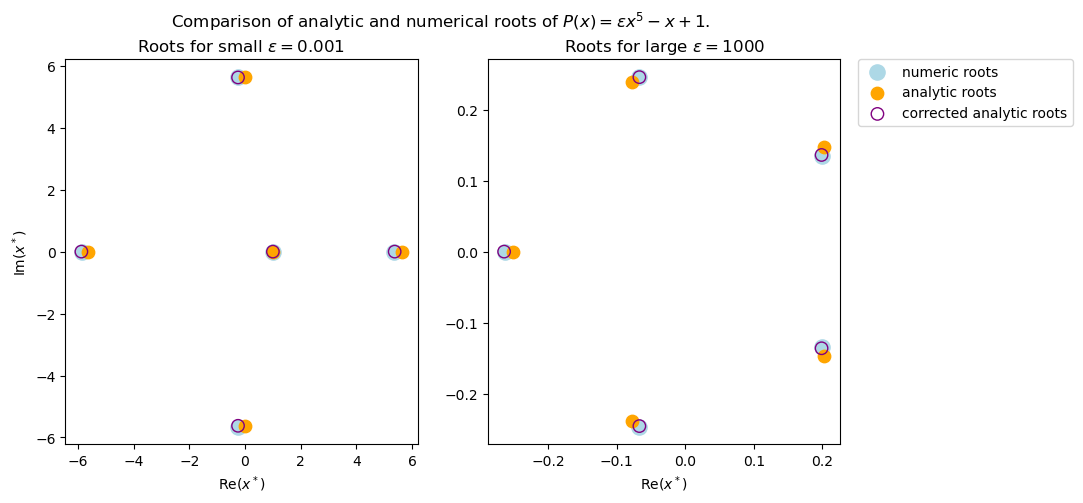

In [ ]:
plot_root_corr(root_to_plot)

#### Plot roots for a range of $\epsilon$ values

In [ ]:
def plot_roots(polynomial, soln_info, x_var=x, eps_var=eps):

    poly_coeffs = Poly(polynomial, x_var).all_coeffs()
    poly_coeffs.pop(0)

    eps_list = [pow(10, eps) for eps in np.linspace(-2, 3, 500)] # all eps
    y_num_all = np.array([np.roots([epsilon]+poly_coeffs) for epsilon in eps_list])

    eps_mat = np.array(eps_list)[:, None].repeat(len(poly_coeffs), axis=1)
    plt.scatter(np.real(y_num_all), np.imag(y_num_all), s=35, cmap='Blues', c=eps_mat, vmin=10^(-4), vmax=10^7)

    eps_small = np.array(eps_list[:int(len(eps_list)/4)])
    eps_large = np.array(eps_list[-int(len(eps_list)/3):])

    for i, (validity, roots, corrections) in enumerate(soln_info):

        if validity == "small":
            for root, corr in zip(roots, corrections):
                root_func = lambdify(eps, root, "numpy")
                corr_func = lambdify(eps, corr, "numpy")

                small_roots_real = np.real(root_func(eps_small))
                small_roots_imag = np.imag(root_func(eps_small))
                plt.scatter(small_roots_real, small_roots_imag, s=1, color='#8fce00')

                delta_re = np.real(corr_func(eps_small))
                delta_im = np.imag(corr_func(eps_small))
                plt.scatter(small_roots_real+delta_re, small_roots_imag+delta_im,
                            s=1, color='purple')

        else:
            for root, corr in zip(roots, corrections):
                large_roots_real = [re(root.subs(eps, eps_val)) for eps_val in eps_large]
                large_roots_imag = [im(root.subs(eps, eps_val)) for eps_val in eps_large]
                plt.scatter(large_roots_real, large_roots_imag, s=1, color='pink')

                delta_re = [re(corr.subs(eps, eps_val)) for eps_val in eps_large]
                delta_im = [im(corr.subs(eps, eps_val)) for eps_val in eps_large]
                plt.scatter(large_roots_real+delta_re, large_roots_imag+delta_im,
                            s=1, color='orange')

    labels = ['numerical solutions, coloured by $\epsilon$',
              'analytical solutions for small $\epsilon$',
              'corrected solutions for small $\epsilon$',
              'analytical solutions for large $\epsilon$',
              'corrected solutions for large $\epsilon$']
    num = Patch(color='#6ca9e0')
    ana_small = Patch(color='#8fce00')
    corr_small = Patch(color='purple')
    ana_large = Patch(color='pink')
    corr_large = Patch(color='darkorange')
    plt.legend([num, ana_small, corr_small, ana_large, corr_large], labels,
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("Re($x^*$)")
    plt.ylabel("Im($x^*$)")
    plt.title("All roots of $P(x)$ plotted on the complex plane.")
    plt.savefig("all_eps_plot.png")
    plt.show()


In [ ]:
x, eps = symbols('x epsilon')
polynomial = eps * x**5 - x + 1
plot_roots(polynomial, soln_info, x_var=x, eps_var=eps)

NameError: ignored

In [ ]:
"""eps_list = [pow(10, eps) for eps in np.linspace(-2, 3, int((7)/0.001))] # all eps
y_num_all = np.array([np.roots([eps, 0, 0, 0, -1, 1]) for eps in eps_list])

eps_mat = np.array(eps_list)[:, None].repeat(5, axis=1) # repeat needs to be same as poly degree
plt.scatter(np.real(y_num_all), np.imag(y_num_all), s=35, cmap='Blues', c=eps_mat, vmin=10^(-4), vmax=10^7, label=r"numerical solutions, coloured by $\epsilon$")

eps_small = eps_list[:int(len(eps_list)/4)]
eps_large = eps_list[-int(len(eps_list)/3):]

for i, (validity, roots, corrections) in enumerate(soln_info):
  # evaluate small roots at small eps and large at large
  if validity == "small":
    for j in range(len(roots)):
      root = roots[j]
      small_roots_real = [re(root.subs(eps, eps_val)) for eps_val in eps_small]
      small_roots_imag = [im(root.subs(eps, eps_val)) for eps_val in eps_small]
      plt.scatter(small_roots_real, small_roots_imag, s=1, color='purple',
                  label='analytical solutions for small $\epsilon$')

      corr = corrections[j]
      delta_re = [re(corr.subs(eps, eps_val)) for eps_val in eps_small]
      delta_im = [im(corr.subs(eps, eps_val)) for eps_val in eps_small]
      plt.scatter(small_roots_real+delta_re, small_roots_imag+delta_im,
                  s=1, color='pink', label='corrected solutions for small $\epsilon$')

  else:
    for j in range(len(roots)):
      root = roots[j]
      large_roots_real = [re(root.subs(eps, eps_val)) for eps_val in eps_large]
      large_roots_imag = [im(root.subs(eps, eps_val)) for eps_val in eps_large]
      plt.scatter(large_roots_real, large_roots_imag, s=1, color='orange',
                  label='analytical solutions for large $\epsilon$')

      corr = corrections[j]
      delta_re = [re(corr.subs(eps, eps_val)) for eps_val in eps_large]
      delta_im = [im(corr.subs(eps, eps_val)) for eps_val in eps_large]
      plt.scatter(large_roots_real+delta_re, large_roots_imag+delta_im,
                  s=1, color='red', label='corrected solutions for small $\epsilon$')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Re($x^*$)")
plt.ylabel("Im($x^*$)")
plt.title("All roots of $P(x)$ plotted on the complex plane.")
plt.show()"""

'eps_list = [pow(10, eps) for eps in np.linspace(-2, 3, int((7)/0.001))] # all eps\ny_num_all = np.array([np.roots([eps, 0, 0, 0, -1, 1]) for eps in eps_list])\n\neps_mat = np.array(eps_list)[:, None].repeat(5, axis=1) # repeat needs to be same as poly degree\nplt.scatter(np.real(y_num_all), np.imag(y_num_all), s=35, cmap=\'Blues\', c=eps_mat, vmin=10^(-4), vmax=10^7, label=r"numerical solutions, coloured by $\\epsilon$")\n\neps_small = eps_list[:int(len(eps_list)/4)]\neps_large = eps_list[-int(len(eps_list)/3):]\n\nfor i, (validity, roots, corrections) in enumerate(soln_info):\n  # evaluate small roots at small eps and large at large\n  if validity == "small":\n    for j in range(len(roots)):\n      root = roots[j]\n      small_roots_real = [re(root.subs(eps, eps_val)) for eps_val in eps_small]\n      small_roots_imag = [im(root.subs(eps, eps_val)) for eps_val in eps_small]\n      plt.scatter(small_roots_real, small_roots_imag, s=1, color=\'purple\',\n                  label=\'analyti

---
# Generate problems, save results to pandas dataframe, export to excel in desired format

### Generate type 1

In [ ]:
# Number of desired problems to generate for each type:
n_problems = 1000
# Create empty dataframe
df = pd.DataFrame(columns=['Question', 'Answer'])

# Problem type 1
for i in tqdm(range(n_problems)):
    n1, n2 = generate_n1n2(max_degree=10)
    question, answer = nondimensionalize_polynomial1(n1, n2)
    row_df = pd.DataFrame({'Question': [question], 'Answer': [answer]})
    df = pd.concat([df, row_df], ignore_index=True)

# Save dataframe to excel file of specified format
df.to_excel('polynomial_dataset.xlsx', index=False)

100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 118.52it/s]


### Generate type 2

In [ ]:
# Number of desired problems to generate for each type:
n_problems = 1000
# Create empty dataframe
df = pd.DataFrame(columns=['Question', 'Answer'])

# Problem type 2
for i in tqdm(range(n_problems)):
    try:
      coefficients = generate_polynomial(max_degree=10, num_terms=3, coeff_bounds=[-10,10])
      new_question, new_answer = nondimensionalize_polynomial2(coefficients)
      # Add new question answer pair to data
      row_df = pd.DataFrame({'Question': [new_question], 'Answer': [new_answer]})
      df = pd.concat([df, row_df], ignore_index=True)
    except:
      continue

# Save dataframe to excel file of specified format
df.to_excel('polynomial_dataset.xlsx', index=False)

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.61it/s]


### Generate type 3

In [ ]:
# Number of desired problems to generate for each type:
n_problems = 1000
# Create empty dataframe
df = pd.DataFrame(columns=['Question', 'Answer'])

# Problem type 3
for i in tqdm(range(n_problems)):
    try:
      polynomial = generate_nondimensionalized(20)
      soln_info, q, a = solve_roots(polynomial)
      # Add new question answer pair to data
      row_df = pd.DataFrame({'Question': [q], 'Answer': [a]})
      df = pd.concat([df, row_df], ignore_index=True)
    except:
      continue

# Save dataframe to excel file of specified format
df.to_excel('polynomial_dataset.xlsx', index=False)

100%|███████████████████████████████████████| 1000/1000 [08:46<00:00,  1.90it/s]


### Generate type 3 & 4 together

In [ ]:
TIMEOUT = 5 # seconds

def timeout(func, args=(), kwargs={}, timeout_duration=TIMEOUT):
    def handler(signum, frame):
        raise TimeoutError()

    old_handler = signal.signal(signal.SIGALRM, handler)
    try:
        signal.alarm(timeout_duration)
        result = func(*args, **kwargs)
    finally:
        signal.signal(signal.SIGALRM, old_handler)
    signal.alarm(0)
    return result

In [ ]:
# Number of desired problems to generate for each type:
n_problems = 100

# Create empty dataframe
df = pd.DataFrame(columns=['Question', 'Answer'])

for i in tqdm(range(n_problems)):
    while True:
        try:
            # Problem type 3
            polynomial = generate_nondimensionalized(10)
            soln_info, q, a = solve_roots(polynomial)

            # Problem type 4
            x, eps = symbols('x epsilon')
            order = random.choice([1, 2])
            soln_info, newq, newa = timeout(get_delta_corrections,
                                            args=(soln_info, polynomial, x),
                                            kwargs={'eps_var': eps, 'term_trunc': order+1})

            # check validity of roots and corrections (3 and 4)
            good_roots, good_corr, comparisons = check_roots(soln_info,
                                                             polynomial,
                                                             x_var=x, eps_var=eps)
            if (good_roots and good_corr):
              # add both rows to df
              row_df = pd.DataFrame({'Question': [q], 'Answer': [a]})
              df = pd.concat([df, row_df], ignore_index=True)
              row_df = pd.DataFrame({'Question': [newq], 'Answer': [newa]})
              df = pd.concat([df, row_df], ignore_index=True)

            else:
              print(f"approx for polynomial {polynomial} not good enough")

            break  # breaks while loop if no exception

        except TimeoutError:
            continue # handle timeout by starting over


# Save dataframe to excel file of specified format
df.to_excel('polynomial_dataset.xlsx', index=False)

100%|█████████████████████████████████████████| 100/100 [08:04<00:00,  4.85s/it]
